## Preprocessing

### retrive data

In [13]:
import pandas as pd

data = pd.read_csv('fukushima-dataset/after_measurements_diff_lal_long.csv')
data = data.drop_duplicates()

type(data)

pandas.core.frame.DataFrame

### data properties

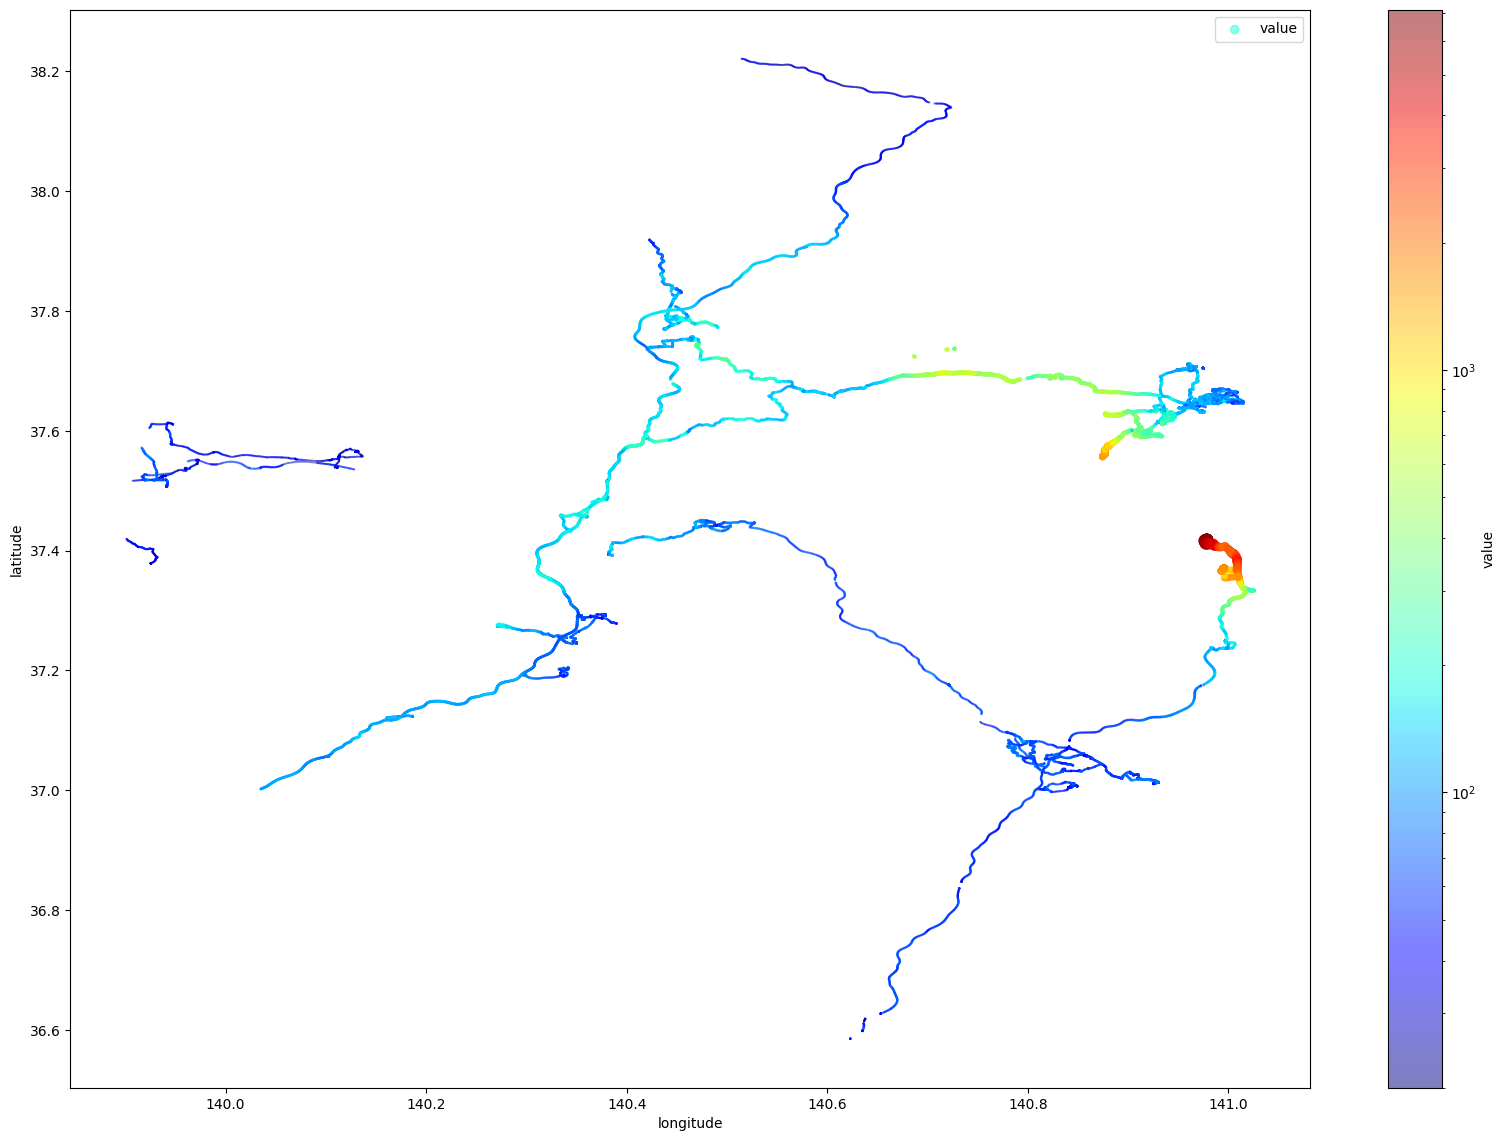

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
    s=data["value"]/100, label="value", figsize=(20,14),
    c="value", cmap=plt.get_cmap("jet"), colorbar=True, norm=pltcolors.LogNorm(20),
    sharex=False
)
plt.legend()

### get feature, target

In [24]:
from sklearn.preprocessing import StandardScaler

y = list(map(float, data['value']))

scaler = StandardScaler()
x_columns = list(data.columns.difference(['value']))
# x = scaler.fit_transform(data[x_columns])
x = data[x_columns]

x

,diff,latitude,longitude
0,310421,37.62881,140.939337
1,310426,37.62881,140.939337
2,310431,37.62881,140.939337
3,310436,37.62881,140.939337
4,310441,37.62881,140.939337
...,...,...,...
42012,34887,37.63791,140.957710
42013,34882,37.63791,140.957710
42014,34877,37.63791,140.956562
42015,34872,37.63791,140.955413


### train / test data

In [25]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    x, 
    y, 
    test_size = 0.2,
    random_state = 0
)

train_x

,diff,latitude,longitude
41278,64167,37.289335,140.351057
5261,911999,37.059765,140.831607
29639,379642,37.507573,139.941232
8122,1585410,37.750293,140.446063
18308,928890,37.710578,140.959423
...,...,...,...
21269,916296,37.750652,140.447262
37130,138733,38.075412,140.673590
35430,142935,37.637910,140.955413
22269,913773,37.567962,140.397053


## Regression model

### fit gradient boosting model

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.3,
    max_depth=5,
    random_state=0,
).fit(train_x, train_y)

### prediction score / importance

In [27]:
from sklearn.metrics import r2_score

predict_test_y = gradient_model.predict(test_x)
predict_train_y = gradient_model.predict(train_x)

print(r2_score(train_y, predict_train_y))
print(r2_score(test_y, predict_test_y))

print(f'model : {gradient_model.feature_importances_}')

0.999532620686769
0.9972352973898958
model : [0.48843944 0.24461501 0.26694555]


## Heatmap

### predict data for heatmap (diff, lal, long)

In [28]:
import numpy as np

time_diff = 2000
step = 2

long_start = 138
long_end = 142

lal_end = 40
lal_start = 36

# arange floating point
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)

def create_dict_data(time_diff, step):
    dict_data = dict()
    
    for longitude in safe_arange(long_start, long_end, step):
        data = list()

        for latitude in safe_arange(lal_end, lal_start, -step):
            # data.append([time_diff])
            data.append([time_diff, latitude, longitude])

        df_data = pd.DataFrame(data, columns=['diff', 'latitude', 'longitude'])    
        # df_data = pd.DataFrame(data, columns=['diff'])    
        predict_data = gradient_model.predict(df_data)

        dict_data[longitude] = list(map(int, predict_data))
        
    return dict_data

### modify to dataframe

In [29]:
def modify_dataframe(dict_data, step):
    #140 ~ 141, 37.8 ~ 36.8
    columns = list(safe_arange(long_start, long_end, step))
    rows = list(safe_arange(lal_end, lal_start, -step))

    dataframe = pd.DataFrame(dict_data, columns=columns, index=rows)
    return dataframe

### draw heatmap (step)


0.1


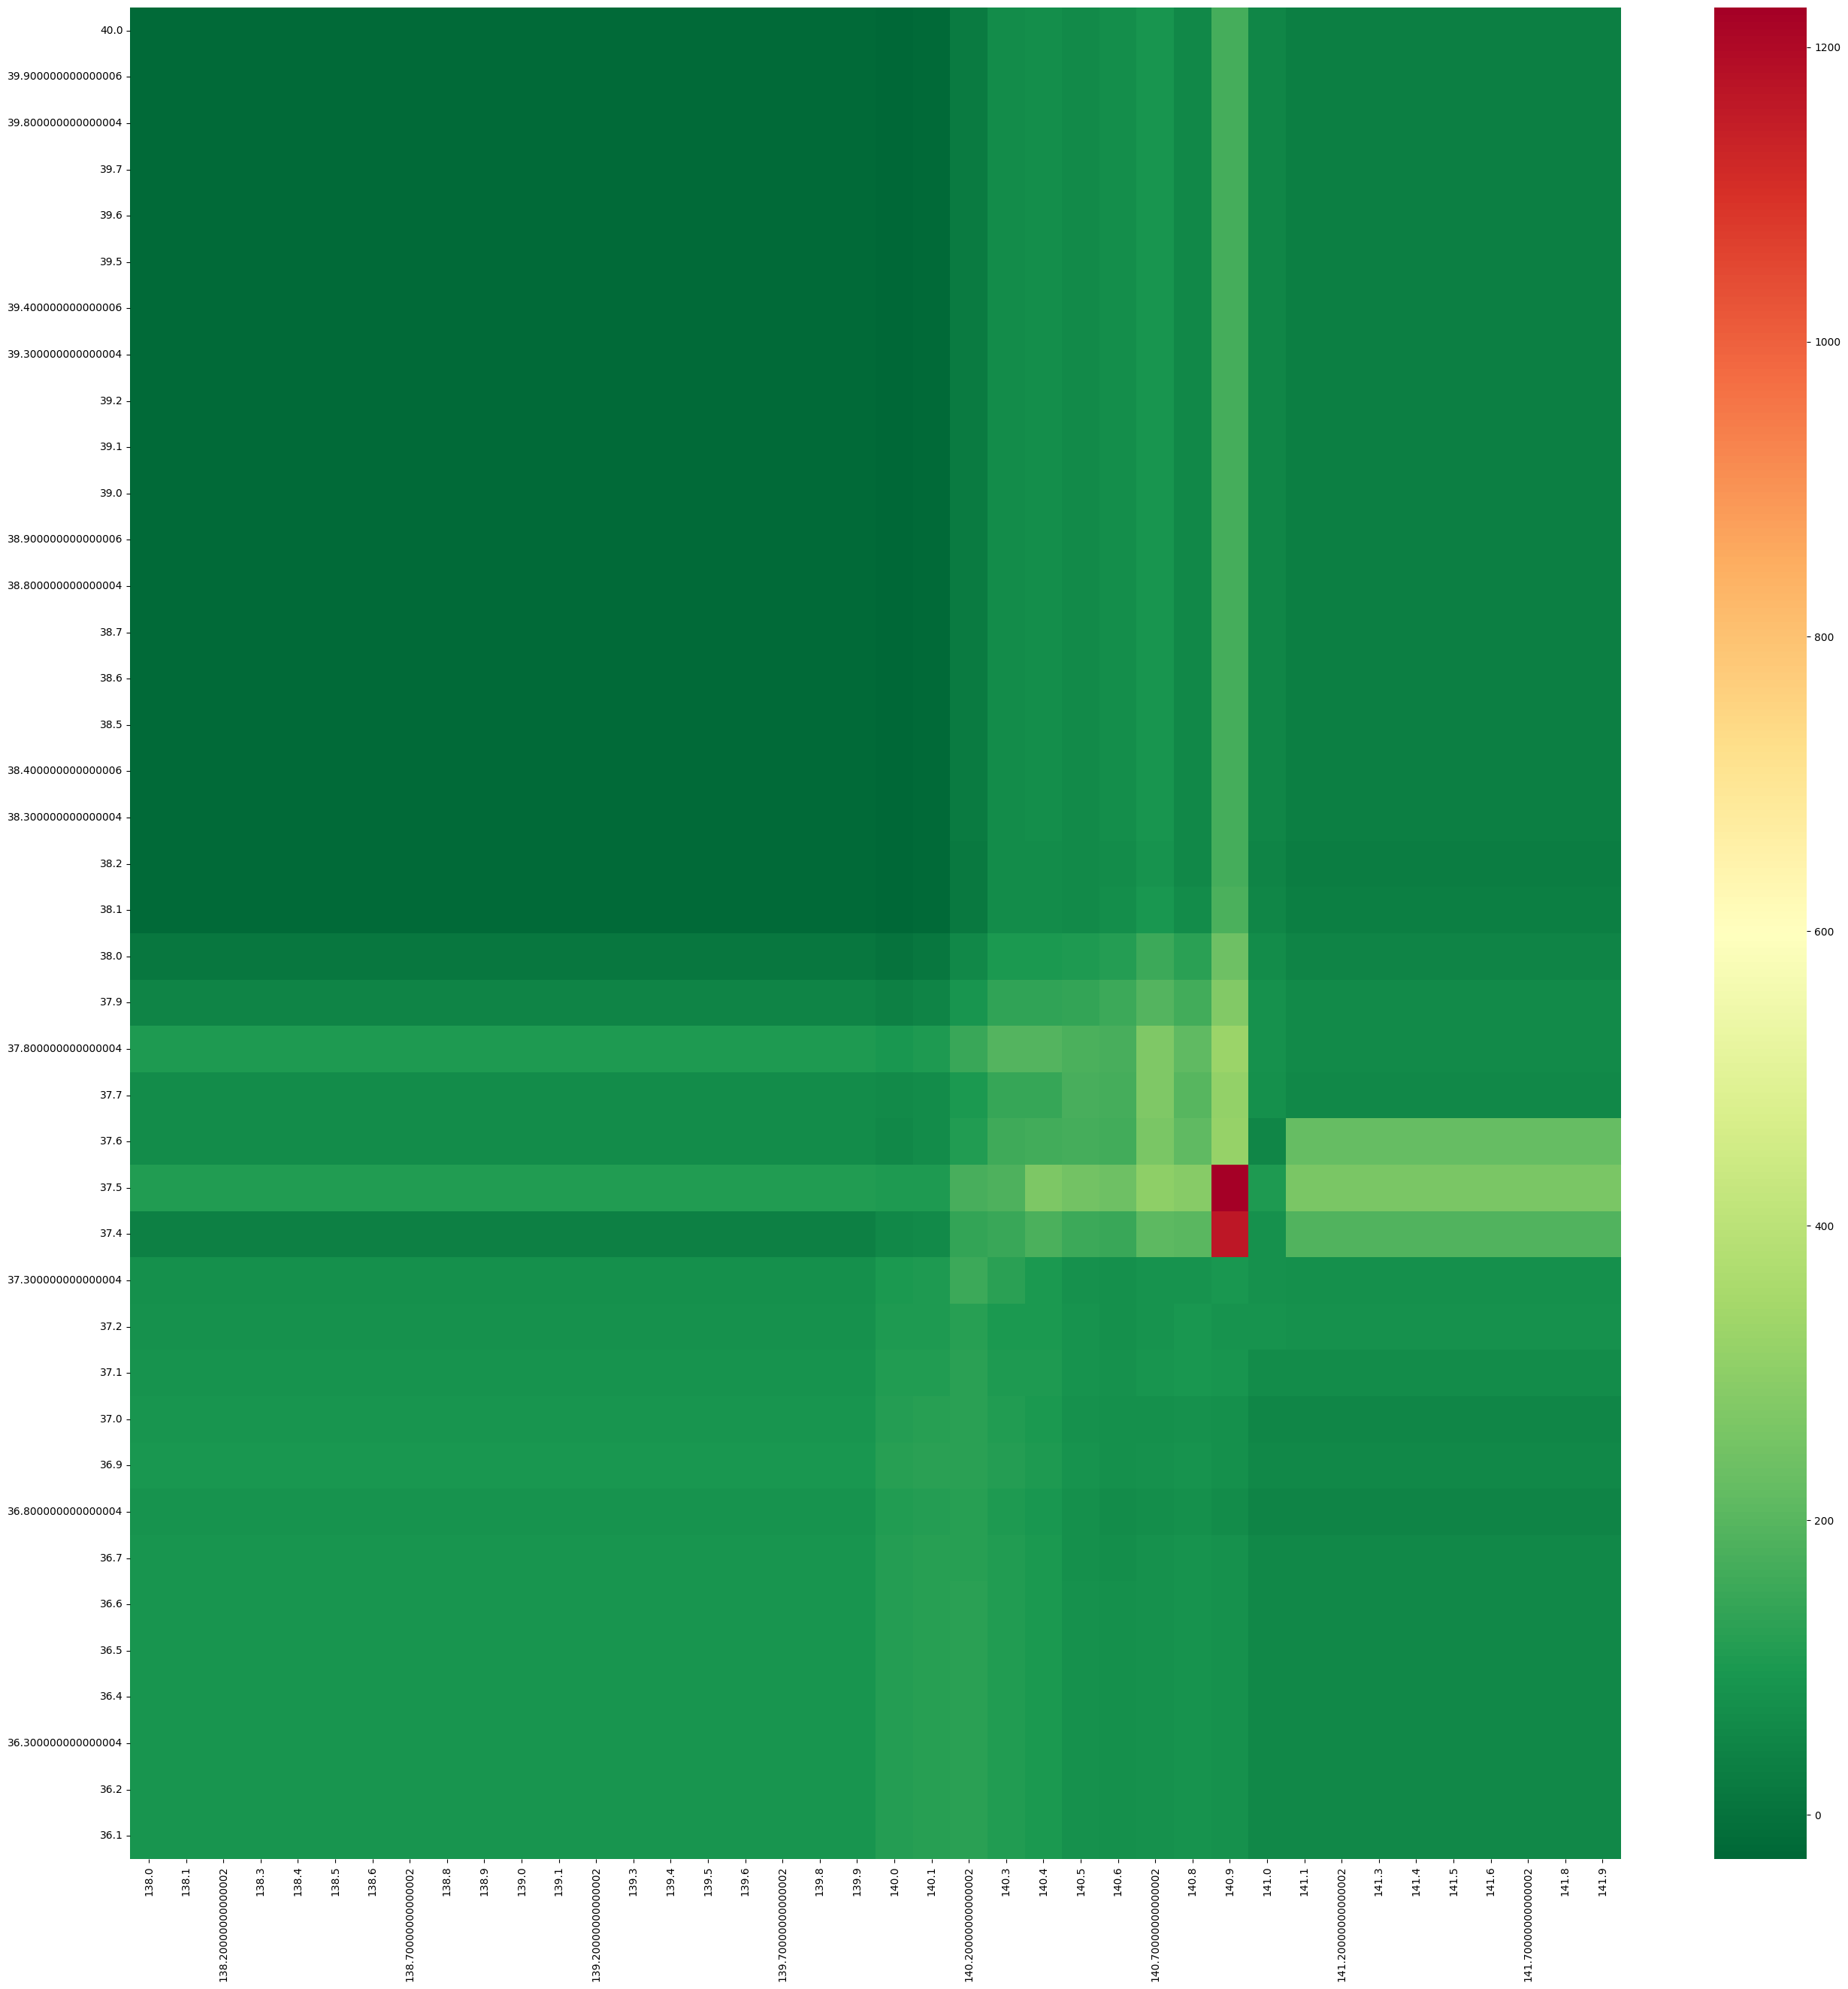

In [39]:
import seaborn as sns

for t in range(1):
    step = 2
    i = 1
    while step > 1:
        print(step)
        dict_data = create_dict_data(t, step)
        data_frame = modify_dataframe(dict_data, step)

        fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharey=True)
        heatmap = sns.heatmap(data_frame, annot=False, cmap='RdYlGn_r',linewidths=0.0025, fmt='g')

        fig = heatmap.get_figure()
        fig.savefig(f"heatmap/{i}_{t}_{step}.png")

        plt.close() 

        step = step / 1.25
        i += 1

### draw heatmap (diff)


In [ ]:
import seaborn as sns

for t in range(0):
    dict_data = create_dict_data(t, step)
    data_frame = modify_dataframe(dict_data, step)

    fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharey=True)
    heatmap = sns.heatmap(data_frame, annot=False, cmap='RdYlGn_r',linewidths=0.0025, fmt='g')

    fig = heatmap.get_figure()
    fig.savefig(f"heatmap/{i}_{t}_{step}.png")

    plt.close()

2
1.6
1.28
1.024
